TODO:
- Include correlation metric
- Calculate min/max of timestamp
- Make code that plots total energy hist for day for each appliance
- Make code that plots max diff timestamp by day. And can calculate % of expected number of datapoints. Then come up with list of appropriate house/date combinations.
- Fix data for homes that have different ...?
- Show histogram of energy used in each home.
- Show histogram of energy used by appliances in each home.
- Replicate table 3.4 from Chaoyun's paper
- Full day of data for each home on each day? Day 1: 20 homes with complete data, Day 2:...
- Solar panels - ignore these homes (11 and 21)
- Mystery kettle
- House 12 has kettle mistake (says 6 when it should be 4). See 
- Check Chaoyun's code

In [108]:
import os
import re
import pandas as pd
import numpy as np
import time
import datetime
from collections import OrderedDict
from __future__ import division

import sqlite3

from ggplot import *
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from utils import *
import refit_io
from get_activations import *

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_run = os.path.join(dir_proj, 'run', str(datetime.date.today()))

In [4]:
house_ids = range(1, 22)
house_ids.remove(14)  # no house 14

tz = 'Europe/London'

In [5]:
params_appliance = get_params_appliance()
app_df = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
refit_raw_path = os.path.join(dir_data, 'REFITPowerData111215')

In [6]:
reload(refit_io)
dir_refit = os.path.join(dir_data, 'refit')

In [259]:
# conn = sqlite3.connect(os.path.join(dir_data, 'refit.db'))
# data_import.save_refit_data_to_sqlite(conn, refit_raw_path, nrows=None)
io.save_refit_data(refit_raw_path, 'numpy', dir_refit=dir_refit, dir_data=dir_data, nrows=None)
# conn.close()

In [7]:
len(np.load(os.path.join(dir_refit, 'house1', 'timestamp.npy')))

7633070

In [ ]:
app_df

In [ ]:
def get_house_app_tuples(pattern, return_pd=False):
    is_match = app_df['ApplianceOrig'].str.lower().str.contains(pattern)
    if return_pd:
        return app_df.loc[is_match]
    house_to_app = app_df.loc[is_match][['House', 'ApplianceNum']].values
    return [(h, a) for h, a in house_to_app]


def load_app(house_id, app_num):
    return np.load(os.path.join(dir_refit,
                                'house{}'.format(house_id),
                                'appliance{}.npy'.format(app_num)))


def load_ts(house_id):
    return np.load(os.path.join(dir_refit,
                                'house{}'.format(house_id),
                                'timestamp.npy'))


def get_app_name(house_id, app_num):
    return app_df[(app_df['House'] == house_id) & (app_df['ApplianceNum'] == app_num)]['Appliance'].values[0]


# get_house_app_tuples('fridge')
# get_house_app_tuples('kettle')
# get_house_app_tuples('washing machine')

In [23]:
def get_ts_idx(ts_series, dt_start, dt_end=None):
    '''
    Get index for time of day without having to convert all timestamps in array to dateitmes.
    '''
    ts_start = dt2ts(dt_start)
    if dt_end is None:
        # Assume one day.
        ts_end = dt2ts(dt_start + datetime.timedelta(days=1))
    else:
        ts_end = dt2ts(dt_end)
    ts_series = pd.DataFrame(ts_series).set_index(0).index
    return (ts_series >= ts_start) & (ts_series < ts_end)


def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, convert_to_datetime=False, set_index=False):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    
    # Load time series for house and get timestamps for specified date.
    ts_series = load_ts(house_id)
    
    # Add first column to df (timestamp).
    df = pd.DataFrame({'timestamp': ts_series})
    
    # Add appliance columns.
    for app_num in range(10):
        if use_app_names:
            app_name = get_app_name(house_id, app_num)
        else:
            app_name = 'appliance{}'.format(app_num)
        df[app_name] = load_app(house_id, app_num)
        
    if dt_start is not None:  # that is, if we don't want all dates
        idx = get_ts_idx(ts_series, dt_start, dt_end)
        df = df.loc[idx]
    
    if convert_to_datetime:
        df['timestamp'] = pd.to_datetime(df.timestamp, unit='s', utc=True)
    if set_index:
        df.set_index('timestamp', inplace=True)
    
    return df


def plot_day(house_id, dt, savefile=None, figsize=(7,5)):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    df = get_df(house_id, use_app_names=True, dt_start=dt, convert_to_datetime=True, set_index=True)
    # df = df.tz_localize('GMT').tz_convert('Europe/London')
    ax = df.plot(figsize=figsize)
    ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
    ax.set_xlabel('')
    # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))
    if savefile is not None:
        plt.savefig(savefile)
    return ax

In [25]:
# Plot day of data for all homes for various days (approx one plot per month).
dt_start = datetime.datetime(2013,11,1)  # around first day of data
for house_id in house_ids:
    
    print 'making plots for house {}...'.format(house_id)
    
    house_dir = os.path.join(dir_run, 'daily_power', 'house{}'.format(house_id))
    if not os.path.exists(house_dir):
        os.makedirs(house_dir)
    
    # Iterate over num months to add to starting datetime.
    for days_to_add in np.array(range(20))*31:
        dt = dt_start + datetime.timedelta(days=days_to_add)
        savefile = os.path.join(house_dir, '{}.pdf'.format(str(dt.date())))
        try:
            plot_day(house_id, dt, savefile)
        except TypeError:
            # DataFrame has no columns b/c there's no data for that day.
            pass
            # print 'No data to plot for house{}_{}.pdf'.format(house_id, str(dt.date()))
        plt.close()

making plots for house 1...
making plots for house 2...
making plots for house 3...
making plots for house 4...
making plots for house 5...
making plots for house 6...
making plots for house 7...
making plots for house 8...
making plots for house 9...
making plots for house 10...
making plots for house 11...
making plots for house 12...
making plots for house 13...
making plots for house 15...
making plots for house 16...
making plots for house 17...
making plots for house 18...
making plots for house 19...
making plots for house 20...
making plots for house 21...


In [ ]:
plot_day(3, datetime.datetime(2015,1,2), figsize=(11,8))

In [207]:
# Define functions to be used in aggregation.
funs = OrderedDict([
    ('RowNum', len),
    ('Timestamp', [min, max]),
    ('TimestampDiff', max),
    ('EnergySumOfParts', sum),
    # ('CorrCoef', lambda x: x.max()),
    ('PctAccountedEnergy', [np.mean, np.std])
])
for app_num in range(10):
    # Calculate total energy used by appliance.
    funs['EnergyAppliance{}'.format(app_num)] = sum


def calc_stats_for_house(house_id, funs, nrow=None):
    '''
    Calculate daily summary stats for each home and some appliance in some home.
    '''
    
    # Import timestamp data, calculate diffs (for calculating energy used by appliances), and set index (for grouping by day)
    ts_series = load_ts(house_id)
    df = pd.DataFrame({'Timestamp': ts_series})
    if nrow is not None:
        df = df.iloc[range(nrow)]
    df['TimestampDiff'] = df['Timestamp']  # will take diff later in grouping
    df['RowNum'] = range(df.shape[0])
    df['Timestamp'] = pd.to_datetime(df.Timestamp, unit='s', utc=True)
    df.set_index('Timestamp', inplace=True)
    # df = df.tz_localize('GMT').tz_convert(tz)
    df = df.groupby(pd.TimeGrouper(freq='D')).transform(lambda x: calc_diff(x, True, 6))
    df['Timestamp'] = df.index  # need this twice: one for grouping and one for calculating stats
    
    # Calculate energy used by appliances.
    df['EnergySumOfParts'] = np.zeros(df.shape[0], dtype=np.int)
    for app_num in range(10):
        app_data = load_app(house_id, app_num)
        if nrow is not None:
            app_data = app_data[range(nrow)]
        df['Appliance{}'.format(app_num)] = app_data
        df['EnergyAppliance{}'.format(app_num)] = df['Appliance{}'.format(app_num)] * df['TimestampDiff']
        if app_num > 0:
            df['EnergySumOfParts'] += df['EnergyAppliance{}'.format(app_num)]
    df['PctAccountedEnergy'] = df['EnergySumOfParts'] / df['EnergyAppliance0'].astype(float)
    # df['CorrCoef'] = np.corrcoef(df['EnergyAppliance0'], df['EnergySumOfParts'])[1,0]
    
    # Aggregate by day and apply functions.
    agg = df.groupby(pd.TimeGrouper(freq='D')).aggregate(funs)
    # agg['PctAccountedEnergy'] = agg['EnergySumOfParts'] / agg['EnergyAppliance0'].astype(float)
    
    return agg

# tmp = calc_stats_for_house(1, funs)

nrow = 100000
agg = []
for house_id in house_ids:
    print 'calculating stats for house {}...'.format(house_id)
    agg_house = calc_stats_for_house(house_id, funs, nrow=nrow)
    agg_house['House'] = house_id
    agg.append(agg_house)
    # print agg
agg = pd.concat(agg)
print 'done!'

calculating stats for house 1...
calculating stats for house 2...
calculating stats for house 3...
calculating stats for house 4...
calculating stats for house 5...
calculating stats for house 6...
calculating stats for house 7...
calculating stats for house 8...
calculating stats for house 9...
calculating stats for house 10...
calculating stats for house 11...
calculating stats for house 12...
calculating stats for house 13...
calculating stats for house 15...
calculating stats for house 16...
calculating stats for house 17...
calculating stats for house 18...
calculating stats for house 19...
calculating stats for house 20...
calculating stats for house 21...
done!


In [208]:
agg

RowNum           Timestamp                     TimestampDiff  \
              len                 min                 max           max   
Timestamp                                                                 
2013-10-09   4804 2013-10-09 13:06:17 2013-10-09 23:59:58        4364.0   
2013-10-10  11760 2013-10-10 00:00:00 2013-10-10 23:59:45         764.0   
2013-10-11  12788 2013-10-11 00:00:00 2013-10-11 23:59:45          50.0   
2013-10-12  13401 2013-10-12 00:00:00 2013-10-12 23:59:58         792.0   
2013-10-13  13951 2013-10-13 00:00:01 2013-10-13 23:59:58          18.0   
2013-10-14  13811 2013-10-14 00:00:01 2013-10-14 23:59:58         649.0   
2013-10-15  13334 2013-10-15 00:00:01 2013-10-15 23:59:58         822.0   
2013-10-16  13175 2013-10-16 00:00:01 2013-10-16 23:59:58         756.0   
2013-10-17   2976 2013-10-17 00:00:00 2013-10-17 05:07:44          18.0   
2013-09-17   1108 2013-09-17 22:08:10 2013-09-17 23:59:58          35.0   
2013-09-18  13134 2013-09-18 00:00:07 2013-09-18 23:59:52        1812.0   
2013-09-19  13860 2013-09-19 00:00:00 2013-09-19 23:59:58         977.0   
2013-09-20  14040 2013-09-20 00:00:07 2013-09-20 23:59:52          24.0   
2013-09-21  13801 2013-09-21 00:00:00 2013-09-21 23:59:52          13.0   
2013-09-22  14252 2013-09-22 00:00:00 2013-09-22 23:59:58          63.0   
2013-09-23  14083 2013-09-23 00:00:05 2013-09-23 23:59:58          17.0   
2013-09-24  14108 2013-09-24 00:00:05 2013-09-24 23:59:58          26.0   
2013-09-25   1614 2013-09-25 00:00:05 2013-09-25 02:41:38           9.0   
2013-09-25   2675 2013-09-25 19:21:09 2013-09-25 23:59:56          24.0   
2013-09-26  13952 2013-09-26 00:00:03 2013-09-26 23:59:58         213.0   
2013-09-27  13403 2013-09-27 00:00:05 2013-09-27 23:59:58        1834.0   
2013-09-28  14062 2013-09-28 00:00:05 2013-09-28 23:59:56          57.0   
2013-09-29  13539 2013-09-29 00:00:03 2013-09-29 23:59:56         582.0   
2013-09-30   5833 2013-09-30 00:00:03 2013-09-30 10:19:03         948.0   
2013-10-01      0                 NaT                 NaT           NaN   
2013-10-02   9434 2013-10-02 08:01:05 2013-10-02 23:59:58         113.0   
2013-10-03  13129 2013-10-03 00:00:09 2013-10-03 23:59:58          78.0   
2013-10-04  13973 2013-10-04 00:00:11 2013-10-04 23:35:27          22.0   
2013-10-11   8340 2013-10-11 10:19:16 2013-10-11 23:59:58         803.0   
2013-10-12  14974 2013-10-12 00:00:00 2013-10-12 23:59:58         768.0   
...           ...                 ...                 ...           ...   
2014-03-10  14001 2014-03-10 00:00:01 2014-03-10 23:59:58          45.0   
2014-03-11  13993 2014-03-11 00:00:01 2014-03-11 23:59:58          52.0   
2014-03-12  13319 2014-03-12 00:00:01 2014-03-12 23:59:58         195.0   
2014-03-13  14071 2014-03-13 00:00:01 2014-03-13 23:59:58          32.0   
2014-03-14   8556 2014-03-14 00:00:01 2014-03-14 14:28:13          19.0   
2014-03-06   4360 2014-03-06 16:23:19 2014-03-06 23:59:58          17.0   
2014-03-07  12964 2014-03-07 00:00:01 2014-03-07 23:59:48         708.0   
2014-03-08  13435 2014-03-08 00:00:00 2014-03-08 23:59:48         601.0   
2014-03-09  14107 2014-03-09 00:00:00 2014-03-09 23:59:48          36.0   
2014-03-10  13482 2014-03-10 00:00:00 2014-03-10 23:59:48        1292.0   
2014-03-11  13433 2014-03-11 00:00:00 2014-03-11 23:59:48          87.0   
2014-03-12  12441 2014-03-12 00:00:00 2014-03-12 23:59:47         695.0   
2014-03-13  13390 2014-03-13 00:00:00 2014-03-13 23:59:48          48.0   
2014-03-14   2388 2014-03-14 00:00:01 2014-03-14 04:09:02         170.0   
2014-03-20   6983 2014-03-20 12:01:19 2014-03-20 23:59:47          41.0   
2014-03-21  13884 2014-03-21 00:00:00 2014-03-21 23:59:50         280.0   
2014-03-22  13982 2014-03-22 00:00:00 2014-03-22 23:59:58          35.0   
2014-03-23  13711 2014-03-23 00:00:01 2014-03-23 23:59:58          39.0   
2014-03-24  13860 2014-03-24 00:00:01 2014-03-24 23:59:48          54.0   
2014-03-25  13932 2014-03-25 00:00:0

In [209]:
agg[('Timestamp', 'max')] - agg[('Timestamp', 'min')]

Timestamp
2013-10-09   10:53:41
2013-10-10   23:59:45
2013-10-11   23:59:45
2013-10-12   23:59:58
2013-10-13   23:59:57
2013-10-14   23:59:57
2013-10-15   23:59:57
2013-10-16   23:59:57
2013-10-17   05:07:44
2013-09-17   01:51:48
2013-09-18   23:59:45
2013-09-19   23:59:58
2013-09-20   23:59:45
2013-09-21   23:59:52
2013-09-22   23:59:58
2013-09-23   23:59:53
2013-09-24   23:59:53
2013-09-25   02:41:33
2013-09-25   04:38:47
2013-09-26   23:59:55
2013-09-27   23:59:53
2013-09-28   23:59:51
2013-09-29   23:59:53
2013-09-30   10:19:00
2013-10-01        NaT
2013-10-02   15:58:53
2013-10-03   23:59:49
2013-10-04   23:35:16
2013-10-11   13:40:42
2013-10-12   23:59:58
               ...   
2014-03-10   23:59:57
2014-03-11   23:59:57
2014-03-12   23:59:57
2014-03-13   23:59:57
2014-03-14   14:28:12
2014-03-06   07:36:39
2014-03-07   23:59:47
2014-03-08   23:59:48
2014-03-09   23:59:48
2014-03-10   23:59:48
2014-03-11   23:59:48
2014-03-12   23:59:47
2014-03-13   23:59:48
2014-03-14   04:09:01


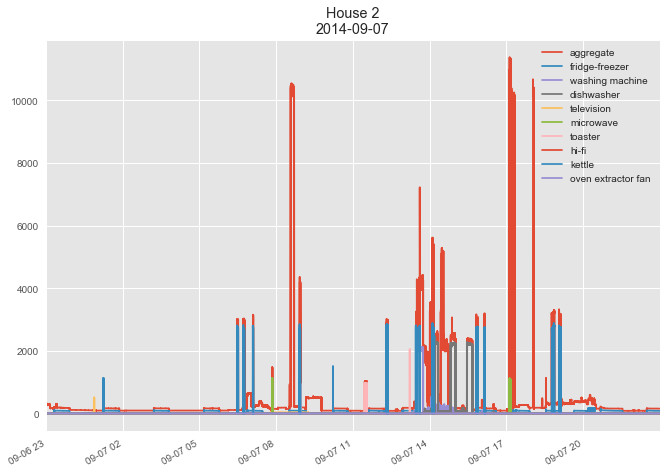

In [197]:
plot_day(2, datetime.datetime(2014,9,7), figsize=(11,8))

In [198]:
get_df(house_id, dt_start=datetime.datetime(2014,7,6)).head(5)  # just very frequent

,timestamp,appliance0,appliance1,appliance2,appliance3,appliance4,appliance5,appliance6,appliance7,appliance8,appliance9
1494429,1404601201,229,93,0,0,0,0,0,0,22,46
1494430,1404601205,228,228,95,0,0,0,0,0,0,20
1494431,1404601205,228,229,95,0,0,0,0,0,0,20
1494432,1404601209,228,93,0,0,0,0,0,0,23,45
1494433,1404601217,228,92,0,0,0,0,0,0,23,45


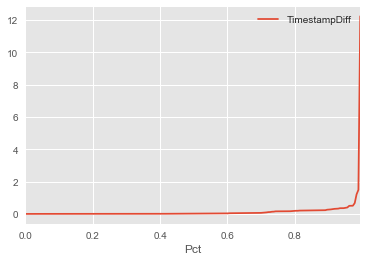

In [204]:
tmp = pd.DataFrame({'TimestampDiff': sorted(agg[('TimestampDiff', 'max')].dropna()/60/60)})
tmp['Pct'] = [i/tmp.shape[0] for i in range(tmp.shape[0])]
tmp.set_index('Pct').plot()

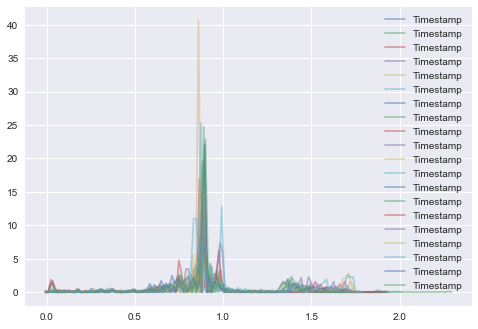

In [296]:
for house_id in house_ids:
    sns.kdeplot(agg.loc[agg['House']==house_id]['Timestamp'], bw=0.002, alpha=0.5)
# sns.kdeplot(agg['Timestamp'], bw=0.002)    

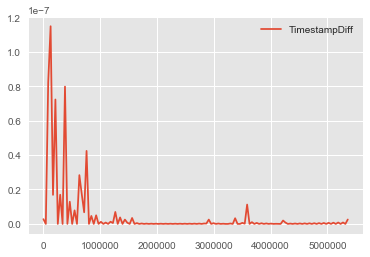

In [31]:
sns.kdeplot(agg['TimestampDiff'], bw=0.002) 

In [39]:
agg.loc[(agg['TimestampDiff'] > 1e6) & (agg['Timestamp']>0.5)].head(10)

,Timestamp,TimestampDiff,EnergyAppliance0,EnergyAppliance1,EnergyAppliance2,EnergyAppliance3,EnergyAppliance4,EnergyAppliance5,EnergyAppliance6,EnergyAppliance7,EnergyAppliance8,EnergyAppliance9,House
Timestamp,,,,,,,,,,,,,
2014-12-23,0.500694,1265568.0,999543841,259458148,0,1857153,32459840,161127,104054834,61950758,1858787,811503,13
2015-05-10,0.846181,1341196.0,395484687,0,0,2820829,4335675,6494950,11357606,89058939,2103058,1849475,13
2014-07-14,0.605694,1562990.0,630780005,153328113,137092409,0,27116094,0,0,117902099,147021,0,16
2014-12-23,0.674306,1268252.0,454077596,113156195,20049696,5345739,4413420,0,35738912,918870,26674280,56169648,21


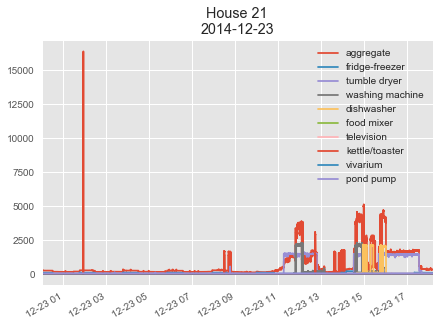

In [40]:
plot_day(21, datetime.datetime(2014,12,23))

In [201]:
def query(string):
    conn = sqlite3.connect(os.path.join(dir_data, 'refit.db'))
    df = pd.read_sql(string, conn)
    conn.close()
    return df


def tt():
    return time.time()


def runtime(t0):
    print '{1:.2g}'.format((tt() - t0) / 60)

In [171]:
# Test
query('SELECT * FROM power LIMIT 3')

,Timestamp,House,Appliance0,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,1381323977,1,523,74,0,69,0,0,0,0,0,1
1,1381323990,1,526,75,0,69,0,0,0,0,0,1
2,1381324005,1,540,74,0,68,0,0,0,0,0,1


In [172]:
# Initialize dict of dataframes for exploratory data analysis
dfs = {}

In [173]:
# Get min and max of timestamp for each home
t0 = tt()
dfs['ts_min_max'] = query('SELECT House, MIN(Timestamp) AS TimestampMin, MAX(Timestamp) AS TimestampMax FROM power GROUP BY House')
runtime(t0)

In [ ]:
pd.DataFrame.from_dict({'House': dfs['ts_min_max']['House'],
                        'DatetimeMin': [str(i.date()) for i in ts2dt(dfs['ts_min_max']['TimestampMin'])],
                        'DatetimeMax': [str(i.date()) for i in ts2dt(dfs['ts_min_max']['TimestampMax'])]})

In [ ]:
# Get appliance statistics for each home. To be used in get_activations().
with sqlite3.connect(os.path.join(dir_data, 'refit.db')) as conn:
    conn.create_aggregate('stdev', 1, StdevFunc)

# Build query string starting with column definitions.
query_str = ['House']
for app_df in range(10):
    query_str.append('MAX(Appliance{0}) AS MaxOnPower, AVG(Appliance{0}) AS MeanPower, STDEV(Appliance{0}) AS StddevPower'.format(app))
query_str = ','.join(query_str)
query_str = 'SELECT ' + query_str + ' FROM power GROUP BY House'
conn = sqlite3.connect(os.path.join(dir_data, 'refit.db'))

# Run query.
t0 = tt()
conn = sqlite3.connect(os.path.join(dir_data, 'refit.db'))
conn.create_aggregate('stdev', 1, StdevFunc)
df = pd.read_sql(query_str, conn)
dfs['app_stats'] = query(query_str)
conn.close()
runtime(t0)